In [1]:
import numpy as np
import scipy as scipy
from scipy import signal
import os
import glob
import matplotlib.pyplot as plt
from numpy.fft import irfft,rfft,rfftfreq
from scipy.signal import hilbert, chirp
from scipy.fftpack import fft
import math
import os
import matplotlib.pyplot as pl
import numpy as np
import scipy as sp
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.fftpack import ifft
import math as m
from scipy.integrate import quad
from numpy.random import randn
from numpy.random import randn
from numpy.fft import rfft, rfftfreq
from numpy.fft import irfft
from scipy.signal import butter, lfilter
from matplotlib.pyplot import loglog
import scipy.special as sc
import scipy.io
from scipy import signal
from scipy import interpolate
import multiprocessing
import os
import glob
import copy
import scipy
import time
import pycwt
import datetime
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft, ifft, next_fast_len
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import signal
import os
import glob
import matplotlib.pyplot as plt
from numpy.fft import irfft,rfft,rfftfreq
from scipy.signal import hilbert, chirp
from scipy.fftpack import fft
import math
import os
import matplotlib.pyplot as pl
import numpy as np
import scipy as sp
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.fftpack import ifft
import math as m
from scipy.integrate import quad
from numpy.random import randn
from numpy.random import randn
from numpy.fft import rfft, rfftfreq
from numpy.fft import irfft
from scipy.signal import butter, lfilter
from matplotlib.pyplot import loglog
import scipy.special as sc
import scipy.io
from scipy import signal
from scipy import interpolate
import multiprocessing
import os
import glob
import copy
import scipy
import time
import pycwt
import datetime
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft, ifft, next_fast_len
import matplotlib.pyplot as plt
import numpy as np
import scipy
if scipy.__version__ < "1.4.0":
    import scipy.fftpack as sf
    from scipy.fftpack.helper import next_fast_len
    import scipy.fftpack._fftpack as sff
else:
    import scipy.fft as sf
    from scipy.fft import next_fast_len
import scipy.optimize
import scipy.signal
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.fftpack import ifft
import math as m
import datetime
import pandas as pd
from scipy.integrate import quad    
from numpy.random import randn
from numpy.random import randn
from numpy.fft import rfft,rfftfreq
from numpy.fft import irfft
from scipy.signal import butter, lfilter
from matplotlib.pyplot import loglog
import scipy.special as sc
import scipy.io
from scipy import signal
from scipy import interpolate
import pandas
import multiprocessing 
from obspy.signal.regression import linear_regression
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def nextpow2(x):
    """
    Returns the next power of 2 of x.
    """
    return int(np.ceil(np.log2(np.abs(x)))) 
def dtw_dvv(ref, cur, para, maxLag, b, direction):
    """
    Dynamic time warping for dv/v estimation.
    
    PARAMETERS:
    ----------------
    ref : reference signal (np.array, size N)
    cur : current signal (np.array, size N)
    para: dict containing useful parameters about the data window and targeted frequency
    maxLag : max number of points to search forward and backward. 
            Suggest setting it larger if window is set larger.
    b : b-value to limit strain, which is to limit the maximum velocity perturbation. 
            See equation 11 in (Mikesell et al. 2015)
    direction: direction to accumulate errors (1=forward, -1=backward)
    RETURNS:
    ------------------
    -m0 : estimated dv/v
    em0 : error of dv/v estimation
    
    Original by Di Yang
    Last modified by Dylan Mikesell (25 Feb. 2015)
    Translated to python by Tim Clements (17 Aug. 2018)    
    """
    t = para['t']
    twin = para['twin']
    dt   = para['dt']
    tmin = np.min(twin)
    tmax = np.max(twin)  
    itvec = np.arange(np.int((tmin-t.min())/dt)+1, np.int((tmax-t.min())/dt)+1)    
    tvec = t[itvec]

    # setup other parameters
    npts = len(ref) # number of time samples
    
    # compute error function over lags, which is independent of strain limit 'b'.
    err = computeErrorFunction( cur, ref, npts, maxLag ) 
    
    # direction to accumulate errors (1=forward, -1=backward)
    dist  = accumulateErrorFunction( direction, err, npts, maxLag, b )
    stbar = backtrackDistanceFunction( -1*direction, dist, err, -maxLag, b )
    stbarTime = stbar * dt   # convert from samples to time
    
    # cut the first and last 5% for better regression
    # indx = np.where((tvec>=0.05*npts*dt) & (tvec<=0.95*npts*dt))[0]
    indx = np.where((tvec>=(0.05*npts*dt+tmin)) & (tvec<=(0.95*npts*dt+tmin)))[0]
    
    # linear regression to get dv/v
    if npts >2:

        # weights
        w = np.ones(npts)
        #m, a, em, ea = linear_regression(time_axis[indx], delta_t[indx], w, intercept_origin=False)
        m0, em0 = linear_regression(tvec.flatten()[indx], stbarTime.flatten()[indx], w.flatten()[indx], intercept_origin=True)

    else:
        print('not enough points to estimate dv/v for dtw')
        m0=0;em0=0
    
    return m0*100,em0*100,dist
def computeErrorFunction(u1, u0, nSample, lag, norm='L2'):
    """
    compute Error Function used in DTW. The error function is equation 1 in Hale, 2013. You could uncomment the
    L1 norm and comment the L2 norm if you want on Line 29
    
    Parameters
    --------------
    u1:  trace that we want to warp; size = (nsamp,1)
    u0:  reference trace to compare with: size = (nsamp,1)
    nSample: numer of points to compare in the traces
    lag: maximum lag in sample number to search
    norm: 'L2' or 'L1' (default is 'L2')
    
    RETURNS:
    ------------------   
    err: the 2D error function; size = (nsamp,2*lag+1)
    
    Original by Di Yang
    Last modified by Dylan Mikesell (25 Feb. 2015)
    Translated to python by Tim Clements (17 Aug. 2018)
    """

    if lag >= nSample: 
        raise ValueError('computeErrorFunction:lagProblem','lag must be smaller than nSample')

    # Allocate error function variable
    err = np.zeros([nSample, 2 * lag + 1])

    # initial error calculation 
    # loop over lags
    for ll in np.arange(-lag,lag + 1):
        thisLag = ll + lag 

        # loop over samples 
        for ii in range(nSample):
            
            # skip corners for now, we will come back to these
            if (ii + ll >= 0) & (ii + ll < nSample):
                err[ii,thisLag] = u1[ii] - u0[ii + ll]

    if norm == 'L2':
        err = err**2
    elif norm == 'L1':
        err = np.abs(err)

    # Now fix corners with constant extrapolation
    for ll in np.arange(-lag,lag + 1):
        thisLag = ll + lag 

        for ii in range(nSample):
            if ii + ll < 0:
                err[ii, thisLag] = err[-ll, thisLag]

            elif ii + ll > nSample - 1:
                err[ii,thisLag] = err[nSample - ll - 1,thisLag]
    
    return err


def accumulateErrorFunction(dir, err, nSample, lag, b ):
    """
    accumulation of the error, which follows the equation 6 in Hale, 2013.
    Parameters
    --------------
    dir: accumulation direction ( dir > 0 = forward in time, dir <= 0 = backward in time)
    err: the 2D error function; size = (nsamp,2*lag+1)
    nSample: numer of points to compare in the traces
    lag: maximum lag in sample number to search
    b: strain limit (integer value >= 1)
    
    RETURNS:
    ------------------   
    d: the 2D distance function; size = (nsamp,2*lag+1)
    Original by Di Yang
    Last modified by Dylan Mikesell (25 Feb. 2015)
    Translated to python by Tim Clements (17 Aug. 2018)
    """

    # number of lags from [ -lag : +lag ]
    nLag = ( 2 * lag ) + 1

    # allocate distance matrix
    d = np.zeros([nSample, nLag])

    # Setup indices based on forward or backward accumulation direction
    if dir > 0: # FORWARD
        iBegin, iEnd, iInc = 0, nSample - 1, 1
    else: # BACKWARD
        iBegin, iEnd, iInc = nSample - 1, 0, -1 

    # Loop through all times ii in forward or backward direction
    for ii in range(iBegin,iEnd + iInc,iInc):

        # min/max to account for the edges/boundaries
        ji = max([0, min([nSample - 1, ii - iInc])])
        jb = max([0, min([nSample - 1, ii - iInc * b])])

        # loop through all lag 
        for ll in range(nLag):

            # check limits on lag indices 
            lMinus1 = ll - 1

            # check lag index is greater than 0
            if lMinus1 < 0:
                lMinus1 = 0 # make lag = first lag

            lPlus1 = ll + 1 # lag at l+1
            
            # check lag index less than max lag
            if lPlus1 > nLag - 1: 
                lPlus1 = nLag - 1
            
            # get distance at lags (ll-1, ll, ll+1)
            distLminus1 = d[jb, lMinus1] # minus:  d[i-b, j-1]
            distL = d[ji,ll] # actual d[i-1, j]
            distLplus1 = d[jb, lPlus1] # plus d[i-b, j+1]

            if ji != jb: # equation 10 in Hale, 2013
                for kb in range(ji,jb + iInc - 1, -iInc): 
                    distLminus1 = distLminus1 + err[kb, lMinus1]
                    distLplus1 = distLplus1 + err[kb, lPlus1]
            
            # equation 6 (if b=1) or 10 (if b>1) in Hale (2013) after treating boundaries
            d[ii, ll] = err[ii,ll] + min([distLminus1, distL, distLplus1])

    return d


def backtrackDistanceFunction(dir, d, err, lmin, b):
    """
    The function is equation 2 in Hale, 2013.
    Parameters
    --------------
    dir: side to start minimization ( dir > 0 = front, dir <= 0 =  back)
    d : the 2D distance function; size = (nsamp,2*lag+1)
    err: the 2D error function; size = (nsamp,2*lag+1)
    lmin: minimum lag to search over
    b : strain limit (integer value >= 1)
    
    RETURNS:
    ------------------   
    stbar: vector of integer shifts subject to |u(i)-u(i-1)| <= 1/b
    Original by Di Yang
    Last modified by Dylan Mikesell (19 Dec. 2014)
    Translated to python by Tim Clements (17 Aug. 2018)
    """

    nSample, nLag = d.shape
    stbar = np.zeros(nSample)

    # Setup indices based on forward or backward accumulation direction
    if dir > 0: # FORWARD
        iBegin, iEnd, iInc = 0, nSample - 1, 1
    else: # BACKWARD
        iBegin, iEnd, iInc = nSample - 1, 0, -1 

    # start from the end (front or back)
    ll = np.argmin(d[iBegin,:]) # find minimum accumulated distance at front or back depending on 'dir'
    stbar[iBegin] = ll + lmin # absolute value of integer shift

    # move through all time samples in forward or backward direction
    ii = iBegin

    while ii != iEnd: 

        # min/max for edges/boundaries
        ji = np.max([0, np.min([nSample - 1, ii + iInc])])
        jb = np.max([0, np.min([nSample - 1, ii + iInc * b])])

        # check limits on lag indices 
        lMinus1 = ll - 1

        if lMinus1 < 0: # check lag index is greater than 1
            lMinus1 = 0 # make lag = first lag

        lPlus1 = ll + 1

        if lPlus1 > nLag - 1: # check lag index less than max lag
            lPlus1 = nLag - 1

        # get distance at lags (ll-1, ll, ll+1)
        distLminus1 = d[jb, lMinus1] # minus:  d[i-b, j-1]
        distL = d[ji,ll] # actual d[i-1, j]
        distLplus1 = d[jb, lPlus1] # plus d[i-b, j+1]

        # equation 10 in Hale (2013)
        # sum errors over i-1:i-b+1
        if ji != jb:
            for kb in range(ji, jb - iInc - 1, iInc):
                distLminus1 = distLminus1 + err[kb, lMinus1]
                distLplus1  = distLplus1  + err[kb, lPlus1]
        
        # update minimum distance to previous sample
        dl = np.min([distLminus1, distL, distLplus1 ])

        if dl != distL: # then ll ~= ll and we check forward and backward
            if dl == distLminus1:
                ll = lMinus1
            else: 
                ll = lPlus1
        
        # assume ii = ii - 1
        ii += iInc 

        # absolute integer of lag
        stbar[ii] = ll + lmin 

        # now move to correct time index, if smoothing difference over many
        # time samples using 'b'
        if (ll == lMinus1) | (ll == lPlus1): # check edges to see about b values
            if ji != jb: # if b>1 then need to move more steps
                for kb in range(ji, jb - iInc - 1, iInc):
                    ii = ii + iInc # move from i-1:i-b-1
                    stbar[ii] = ll + lmin  # constant lag over that time

    return stbar

def cosine_taper(npts, p=0.1, freqs=None, flimit=None, halfcosine=True,
                 sactaper=False):
    """
    Cosine Taper.

    :type npts: int
    :param npts: Number of points of cosine taper.
    :type p: float
    :param p: Decimal percentage of cosine taper (ranging from 0 to 1). Default
        is 0.1 (10%) which tapers 5% from the beginning and 5% form the end.
    :rtype: float NumPy :class:`~numpy.ndarray`
    :return: Cosine taper array/vector of length npts.
    :type freqs: NumPy :class:`~numpy.ndarray`
    :param freqs: Frequencies as, for example, returned by fftfreq
    :type flimit: list(float, float, float, float) or
        tuple(float, float, float, float)
    :param flimit: The list or tuple defines the four corner frequencies
        (f1, f2, f3, f4) of the cosine taper which is one between f2 and f3 and
        tapers to zero for f1 < f < f2 and f3 < f < f4.
    :type halfcosine: bool
    :param halfcosine: If True the taper is a half cosine function. If False it
        is a quarter cosine function.
    :type sactaper: bool
    :param sactaper: If set to True the cosine taper already tapers at the
        corner frequency (SAC behavior). By default, the taper has a value
        of 1.0 at the corner frequencies.

    .. rubric:: Example

    >>> tap = cosine_taper(100, 1.0)
    >>> tap2 = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 50)))
    >>> np.allclose(tap[0:50], tap2)
    True
    >>> npts = 100
    >>> p = 0.1
    >>> tap3 = cosine_taper(npts, p)
    >>> (tap3[int(npts*p/2):int(npts*(1-p/2))]==np.ones(int(npts*(1-p)))).all()
    True
    """
    if p < 0 or p > 1:
        msg = "Decimal taper percentage must be between 0 and 1."
        raise ValueError(msg)
    if p == 0.0 or p == 1.0:
        frac = int(npts * p / 2.0)
    else:
        frac = int(npts * p / 2.0 + 0.5)

    if freqs is not None and flimit is not None:
        fl1, fl2, fl3, fl4 = flimit
        idx1 = np.argmin(abs(freqs - fl1))
        idx2 = np.argmin(abs(freqs - fl2))
        idx3 = np.argmin(abs(freqs - fl3))
        idx4 = np.argmin(abs(freqs - fl4))
    else:
        idx1 = 0
        idx2 = frac - 1
        idx3 = npts - frac
        idx4 = npts - 1
    if sactaper:
        # in SAC the second and third
        # index are already tapered
        idx2 += 1
        idx3 -= 1

    # Very small data lengths or small decimal taper percentages can result in
    # idx1 == idx2 and idx3 == idx4. This breaks the following calculations.
    if idx1 == idx2:
        idx2 += 1
    if idx3 == idx4:
        idx3 -= 1

    # the taper at idx1 and idx4 equals zero and
    # at idx2 and idx3 equals one
    cos_win = np.zeros(npts)
    if halfcosine:
        # cos_win[idx1:idx2+1] =  0.5 * (1.0 + np.cos((np.pi * \
        #    (idx2 - np.arange(idx1, idx2+1)) / (idx2 - idx1))))
        cos_win[idx1:idx2 + 1] = 0.5 * (
            1.0 - np.cos((np.pi * (np.arange(idx1, idx2 + 1) - float(idx1)) /
                          (idx2 - idx1))))
        cos_win[idx2 + 1:idx3] = 1.0
        cos_win[idx3:idx4 + 1] = 0.5 * (
            1.0 + np.cos((np.pi * (float(idx3) - np.arange(idx3, idx4 + 1)) /
                          (idx4 - idx3))))
    else:
        cos_win[idx1:idx2 + 1] = np.cos(-(
            np.pi / 2.0 * (float(idx2) -
                           np.arange(idx1, idx2 + 1)) / (idx2 - idx1)))
        cos_win[idx2 + 1:idx3] = 1.0
        cos_win[idx3:idx4 + 1] = np.cos((
            np.pi / 2.0 * (float(idx3) -
                           np.arange(idx3, idx4 + 1)) / (idx4 - idx3)))

    # if indices are identical division by zero
    # causes NaN values in cos_win
    if idx1 == idx2:
        cos_win[idx1] = 0.0
    if idx3 == idx4:
        cos_win[idx3] = 0.0
    return cos_win

def smooth(x, window='boxcar', half_win=3):
    """ 
    performs smoothing in interested time window
    Parameters
    --------------
    x: timeseris data
    window: types of window to do smoothing
    half_win: half window length
    RETURNS:
    ------------------   
    y: smoothed time window 
    """
    # TODO: docsting
    window_len = 2 * half_win + 1
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len - 1:0:-1], x, x[-1:-window_len:-1]]
    if window == "boxcar":
        w = scipy.signal.boxcar(window_len).astype('complex')
    else:
        w = scipy.signal.hanning(window_len).astype('complex')
    y = np.convolve(w / w.sum(), s, mode='valid')
    return y[half_win:len(y) - half_win]


def getCoherence(dcs, ds1, ds2):
    """
    get cross coherence between reference and current waveforms following equation of A3 in Clark et al., 2011
    Parameters
    --------------
    dcs: amplitude of the cross spectrum
    ds1: amplitude of the spectrum of current waveform
    ds2: amplitude of the spectrum of reference waveform
    
    RETURNS:
    ------------------  
    coh: cohrerency matrix used for estimate the robustness of the cross spectrum 
    """
    n = len(dcs)
    coh = np.zeros(n).astype('complex')
    valids = np.argwhere(np.logical_and(np.abs(ds1) > 0, np.abs(ds2) > 0))
    coh[valids] = dcs[valids] / (ds1[valids] * ds2[valids])
    coh[coh > (1.0 + 0j)] = 1.0 + 0j
    return coh
def __norm(a):
    for i in range(a[i,:].size):
        a[i,:]=__norms(a[i,:])
    return(a)
def __norms(a):
    return(a - np.min(a))/(np.max(a)-np.min(a))
def cosine_taper(npts, p=0.1, freqs=None, flimit=None, halfcosine=True,
                 sactaper=False):
    """
    Cosine Taper.
    :type npts: int
    :param npts: Number of points of cosine taper.
    :type p: float
    :param p: Decimal percentage of cosine taper (ranging from 0 to 1). Default
        is 0.1 (10%) which tapers 5% from the beginning and 5% form the end.
    :rtype: float NumPy :class:`~numpy.ndarray`
    :return: Cosine taper array/vector of length npts.
    :type freqs: NumPy :class:`~numpy.ndarray`
    :param freqs: Frequencies as, for example, returned by fftfreq
    :type flimit: list(float, float, float, float) or
        tuple(float, float, float, float)
    :param flimit: The list or tuple defines the four corner frequencies
        (f1, f2, f3, f4) of the cosine taper which is one between f2 and f3 and
        tapers to zero for f1 < f < f2 and f3 < f < f4.
    :type halfcosine: bool
    :param halfcosine: If True the taper is a half cosine function. If False it
        is a quarter cosine function.
    :type sactaper: bool
    :param sactaper: If set to True the cosine taper already tapers at the
        corner frequency (SAC behavior). By default, the taper has a value
        of 1.0 at the corner frequencies.

    .. rubric:: Example

    >>> tap = cosine_taper(100, 1.0)
    >>> tap2 = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 50)))
    >>> np.allclose(tap[0:50], tap2)
    True
    >>> npts = 100
    >>> p = 0.1
    >>> tap3 = cosine_taper(npts, p)
    >>> (tap3[int(npts*p/2):int(npts*(1-p/2))]==np.ones(int(npts*(1-p)))).all()
    True
    """
    if p < 0 or p > 1:
        msg = "Decimal taper percentage must be between 0 and 1."
        raise ValueError(msg)
    if p == 0.0 or p == 1.0:
        frac = int(npts * p / 2.0)
    else:
        frac = int(npts * p / 2.0 + 0.5)

    if freqs is not None and flimit is not None:
        fl1, fl2, fl3, fl4 = flimit
        idx1 = np.argmin(abs(freqs - fl1))
        idx2 = np.argmin(abs(freqs - fl2))
        idx3 = np.argmin(abs(freqs - fl3))
        idx4 = np.argmin(abs(freqs - fl4))
    else:
        idx1 = 0
        idx2 = frac - 1
        idx3 = npts - frac
        idx4 = npts - 1
    if sactaper:
        # in SAC the second and third
        # index are already tapered
        idx2 += 1
        idx3 -= 1

    # Very small data lengths or small decimal taper percentages can result in
    # idx1 == idx2 and idx3 == idx4. This breaks the following calculations.
    if idx1 == idx2:
        idx2 += 1
    if idx3 == idx4:
        idx3 -= 1

    # the taper at idx1 and idx4 equals zero and
    # at idx2 and idx3 equals one
    cos_win = np.zeros(npts)
    if halfcosine:
        # cos_win[idx1:idx2+1] =  0.5 * (1.0 + np.cos((np.pi * \
        #    (idx2 - np.arange(idx1, idx2+1)) / (idx2 - idx1))))
        cos_win[idx1:idx2 + 1] = 0.5 * (
            1.0 - np.cos((np.pi * (np.arange(idx1, idx2 + 1) - float(idx1)) /
                          (idx2 - idx1))))
        cos_win[idx2 + 1:idx3] = 1.0
        cos_win[idx3:idx4 + 1] = 0.5 * (
            1.0 + np.cos((np.pi * (float(idx3) - np.arange(idx3, idx4 + 1)) /
                          (idx4 - idx3))))
    else:
        cos_win[idx1:idx2 + 1] = np.cos(-(
            np.pi / 2.0 * (float(idx2) -
                           np.arange(idx1, idx2 + 1)) / (idx2 - idx1)))
        cos_win[idx2 + 1:idx3] = 1.0
        cos_win[idx3:idx4 + 1] = np.cos((
            np.pi / 2.0 * (float(idx3) -
                           np.arange(idx3, idx4 + 1)) / (idx4 - idx3)))

    if idx1 == idx2:
        cos_win[idx1] = 0.0
    if idx3 == idx4:
        cos_win[idx3] = 0.0
    return cos_win
def __filtreX(Xc,corner,order):
    a,b = scipy.signal.butter(1,corner, btype='band',output='ba')
    Xc=(signal.filtfilt(a,b,Xc,axis=1))
    return(Xc)
def __Coeff_epsilon(EPSILON, results, ref, time):
    ref3 = []
    for i in range(EPSILON.size):
        time2 = (time * (1 + EPSILON[i]))
        tck = interpolate.splrep(time, ref, s=0)
        R2 = interpolate.splev(time2, tck, der=0)
        ref3.append(R2[results])
    return (ref3)
def __Coeff_epsilon_2(EPSILON, results, ref, time):
    ref3 = []
    for i in range(EPSILON.size):
        time2 = (time * (1 + EPSILON[i]))
        R2 =  np.interp(x=time, xp=time2, fp=ref)
        ref3.append(R2[results])
        #plt.plot(time2,R2)
    return (ref3)
def __norm(a):
    return(a - np.min(a))/(np.max(a)-np.min(a))
def __normalisation(Xc, t, swtl, ewtl, option_normalisation_dv,results):
    if option_normalisation_dv == 1:
        for i in range(len(Xc[0, :])):
            s=Xc[results, i]
            Xc[results, i] = __norm(s)#signal.detrend(__norm(s))
        return (Xc)
    else:
        return (Xc)
def __smoothing(Xc,lisse_dv,order_SG,option_smoothing_dv):
    S=np.zeros((Xc[:,0].size,Xc[0,:].size))
    if option_smoothing_dv==1:
        for i in range(len(Xc[:,0])):
            S[i,:]=signal.savgol_filter(Xc[i,0:Xc[0,:].size].copy(),lisse_dv,order_SG)
        return(S)
    else :
        return(Xc) 
def __stretching(dv,EPSILON,d,t,results,save_path,f1,f2,mode,vel,ref,t1,t2,st1,st2,K):        
    CC=[]
    Precision=[]
    beta=[]
    #fig, ax = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')
    for i in range(dv.shape[1]):
        if (~np.isnan(dv[:,i])).sum(0)>5:
            B=np.nanargmax((dv[:,i]))
            beta.append(dv[B,i])
            if dv[B,i]>0 :
                dV=100*EPSILON[B]
                CC.append(dV)
                Precision.append(dv[B,i])
            else :
                CC.append(np.nan)
                Precision.append(dv[B,i])
        else :
            CC.append(np.nan)
            Precision.append(np.nan)
    T=np.arange(0,len(CC))
    CC=np.asarray(CC)
    folder_name=rf'{save_path}{f1}_{f2}/{st1}/'
    isExist = os.path.exists(folder_name)
    if not isExist:
       os.makedirs(folder_name)     
    print(f'Save in {folder_name}')
    np.save(rf'{folder_name}{K}_dv_{st1}_{st2}_{mode}_{t1}_{t2}_{f1}_{f2}',CC)
    np.save(rf'{folder_name}{K}_cc_{st1}_{st2}_{mode}_{t1}_{t2}_{f1}_{f2}',dv)
    np.save(rf'{folder_name}{K}_beta_{st1}_{st2}_{mode}_{t1}_{t2}_{f1}_{f2}',beta)
def __make_stretch(Xc,stacks,option_filtre_dv,option_smoothing_dv,option_normalisation_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,mode,precision,save_path,vm,Vm,t1,t2,st1,st2,eps,K,fig):
    """
    Stretching approach based on matrix correlation
    Written Gaubert-Bastide Thomas 2023
    Xc is Correlograms
    stacks modify the size of Xc, put it at 1 if it is not wanted
    option_filtre_dv , if 1 apply a filter in the dvf1-dvf2 frequency band
    option_smoothing_dv, if 1 apply a SVG filter with the lisse_SG length and order_SG polynome
    d is an useless variable, put it at 0.
    v is an useless variable, put it at 0
    t is an useless variable, put it at 0
    dvf1 : minimum frequency band
    dvf2 : maximum frequency band
    lisse_SG = float
    maxlag : number of sample in a full trace 
    mode : Frequence, Acausale, autocorr,Causale,Symmetric,Coda,Q2S,Q2A,Q2_all
    precision useless variable
    save_path path to folder to save
    vm, useless
    Vm, useless
    t1, minimum Time lag to compute stretching
    t2, maximum Time lag to compute Stretching
    st1, Information 1 
    st2, Informaton  2 # Free to add everything on it, f1 f2 t1 t2 etc like :f'{f1}_{f2}_{t1}_{t2}_{mode}'
    eps, Value of max epsilon
    K, # Add more specificity to your file's name
    fig # 1 if u wanna plot, 0 if u doesn't want.
    
    """
    if mode == 'Frequence':
        X=Xc
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,t1,t2,st1,st2,eps,K,fig) 
    if mode == 'Acausale':
        X=np.fliplr(Xc[:,0:maxlag//2])
        print(X.shape)
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,t1,t2,st1,st2,eps,K,fig) 
    if mode == 'autocorr':
        X=Xc[:,1+maxlag//2::]
        #X=((np.fliplr(Xc[:,0:maxlag+1]))+Xc[:,maxlag::])/2
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,t1,t2,st1,st2,eps,K,fig)    
    if mode == 'Causale':
        X=Xc[:,1+maxlag//2::]
        #print('taille :',X.shape)
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,t1,t2,st1,st2,eps,K,fig)    
    if mode == 'Symmetric' or mode =='Coda':
        print(maxlag)
        X=((np.fliplr(Xc[:,0:maxlag//2+1]))+Xc[:,maxlag//2::])/2
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,t1,t2,st1,st2,eps,K,fig)
    if mode == 'Q2S':
        X=((np.fliplr(Xc[:,0:maxlag]))+Xc[:,1+maxlag::])/2
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,st1,st2,eps,K,fig)    
    if mode == 'Q2A':
        X=np.fliplr(Xc[:,0:maxlag])
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,st1,st2,eps,K,fig)   
    if mode == 'Q2C':
        X=Xc[:,1+maxlag::]
        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,st1,st2,eps,K,fig)
    if mode == 'Q2_all':
        X=Xc

        __dvcompute(X,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,Vm,mode,t1,t2,st1,st2,eps,K,fig)
        ########################### MAINRUN ###########################   
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]
    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)
    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))
def __dvcompute(Xc,stacks,option_filtre_dv,option_normalisation_dv,option_smoothing_dv,d,v,t,dvf1,dvf2,lisse_SG,maxlag,precision,save_path,vm,vM,mode,t1,t2,st1,st2,eps,K,fig):
    if mode == 'Frequence':
        print(Xc.shape,t.size)
        EPSILON=np.linspace(-eps*10e-2,eps*10e-2+1e-3,3000)
        swtl=t1#d/vm#v-1/(dvf1+dvf2)
        ewtl=t2#d/vM#d/v+1/(dvf1+dvf2)
    if mode=='Q2_all':
        swtl=t1#d/vm#v-1/(dvf1+dvf2)
        ewtl=t2#d/vM#d/v+1/(dvf1+dvf2)
        t=np.linspace(-maxlag/(2*fs),(maxlag)/(2*fs),maxlag+1)
        EPSILON=np.arange(-eps*10e-2,eps*10e-2+1e-3,1e-3)
        tp=cosine_taper(2501, p=0.1, freqs=None, flimit=None, halfcosine=True,
                 sactaper=False)
        tp1=cosine_taper(2500, p=0.1, freqs=None, flimit=None, halfcosine=True,
                 sactaper=False)
    if mode == 'Q2S' or mode=='Q2A' or mode== 'Q2C':
        swtl=t1#d/vm#v-1/(dvf1+dvf2)
        ewtl=t2#d/vM#d/v+1/(dvf1+dvf2)
        t=np.linspace(0,(maxlag)/fs,maxlag+1)
    if mode == 'Symmetric' or mode=='Acausale' or mode== 'Causale':
        swtl=t1
        ewtl=t2#1/(dvf1+dvf2)
        EPSILON=np.arange(-eps*10e-2,eps*10e-2+1e-4,1e-4)#1e-4
        EPSILON=np.round(EPSILON,5)
        t=np.linspace(0,(maxlag//2)/fs,Xc[0].size)
    if mode =='Coda':# or vmin<200:
        EPSILON=np.linspace(-eps*10e-2,eps*10e-2+1e-3,1000)
        swtl=t1
        ewtl=t2
        t=np.linspace(0,(maxlag)/fs,maxlag+1)
    if mode == 'autocorr':
        swtl=t1
        ewtl=t2#1/(dvf1+dvf2)
        t=np.linspace(0,(maxlag//2)/fs,maxlag//2+1)
        EPSILON=np.arange(-eps*10e-2,eps*10e-2+1e-3,1e-3)
    corner_dv=np.array([dvf1, dvf2]) * 2. * (1/fs)####
    results=np.asarray(np.where(np.logical_and(t>=swtl, t<=ewtl)))
    results=np.asarray(results).reshape(results.size)
    def __stack(Xc, stacks, t, swtl, ewtl):
        if stacks > 1:
            Xc1 = np.zeros((Xc[:, 0].size // stacks, Xc[0, :].size))
            for i in range(Xc1[:, 0].size):
                Xc1[i, :] = np.mean(Xc[i * stacks:i * stacks + stacks, :], axis=0)
            return (Xc1)
        if stacks == 1:
            return (Xc)
    figs=fig
    if figs == 1 :
        fig, ax = plt.subplots(8,1, figsize=(20, 40), facecolor='w', edgecolor='k')
        ax=ax.ravel()
        ax[0].axis('equal')
        ax[0].imshow(Xc,extent=[t[0],t[-1],0,1],aspect='auto',origin='lower')
        ax[0].set_title('raw')
        ax[0].plot(t,0.5+np.mean(Xc,0),'r')
        ax[0].set_xlim(t1,t2)
    #if swtl < 0:
    #   swtl=0.0001

    Xc=__stack(Xc,stacks,t,swtl,ewtl)
    if figs == 1 :
        print('Figure display')
        ax[1].imshow(Xc,extent=[t[0],t[-1],0,1],aspect='auto',origin='lower')
        ax[1].set_title('Stack')
        ax[1].set_xlim(t1,t2)

    #print('1')
    Xc=__filtre(Xc,corner_dv,order,option_filtre_dv,t,swtl,ewtl)
    #for i in range(Xc[0,:].size):
    #    Xc[i]=Xc[i]/np.amax(abs(Xc[i]))
    if figs == 1 :
        ax[2].imshow(Xc.T,extent=[t[0],t[-1],0,1],aspect='auto',origin='lower')
        ax[2].set_title('Filter')
        ax[2].set_xlim(t1,t2)
    #print('2')

    if option_normalisation_dv == 1:
        Xc=__normalisation(Xc,t,swtl,ewtl,option_normalisation_dv,results)
    if figs == 1 :
        ax[3].imshow(Xc.T,extent=[t[0],t[-1],0,1],aspect='auto',origin='lower')
        ax[3].set_title('Normalisation')
    #print('3')

    order_SG=1
    Xc=__smoothing(Xc,lisse_SG,order_SG,option_smoothing_dv)
    if figs == 1 :
        ax[4].imshow(Xc.T,extent=[t[0],t[-1],0,17280],aspect='auto',origin='lower')
        ax[4].set_title('SG')
    #Xc[np.where(t>ewtl),:]=0
    #Xc[np.where(t<swtl),:]=0
    #Xc=np.sign(Xc)
    #print('4')

    if mode == 'Q2_all':
        ref=np.mean(Xc,1)
    else:
        ref=Xc[:,1]##############POURQUOI 24 VINDIOU
        ref=np.mean(Xc,1)
        ref=np.median(Xc[:,1500//6:2250//6],1)
    ref=Xc[:,0] ##Classical
    #ref=signal.detrend(ref)
    #ref=np.median(Xc[:,-200::],1)#signal.detrend(Xc[:,0])

    data=__stretching_prepare(Xc,results)  
    #np.save(rf'E:\Experience\free2\ref/ref_{K}',ref)
    if figs == 1 :
        ax[5].plot(t,ref)
        ax[5].plot(t[results],ref[results],'ro')
        ax[5].set_xlim(t[0],t[-1])
    ref_shifted=__Coeff_epsilon(EPSILON,results,ref,t)

    ##ref_shifted=__Coeff_epsilon_2(EPSILON,results,ref,t)

    ref_shifted=np.asarray(ref_shifted)
    #ref_shifted,N=__coef_stretching_compute(precision,dvf1,dvf2,fs,ref,results,t)
    if figs == 1 :
        ax[6].imshow(ref_shifted.T,aspect='auto')
        ax[6].set_title('Shifted REF')
    dv=corr2_coeff((ref_shifted),(data).transpose())

    if figs == 1 :
        ax[7].imshow((dv),aspect='auto')
    __stretching(dv,EPSILON,d,t,results,save_path,dvf1,dvf2,mode,vm,ref,t1,t2,st1,st2,K)   
def __find(Matrix,reference_number):
    old_arg=np.nanargmax(Matrix[:,reference_number])
    idx=[]
    sigma_y = 30.0
    sigma_x = 30.0
    sigma = [sigma_y, sigma_x]
    Matrix = sp.ndimage.filters.gaussian_filter(Matrix, sigma, mode='nearest')
    for i in range(0,Matrix[0,:].size):
        if i <reference_number:
            idx.append(np.nanargmax(Matrix[:,i]))
        if i > reference_number:
            a=scipy.signal.find_peaks(Matrix[:,i])
            arg=a[0][int(np.nanargmin(abs(np.asarray(a[0]).astype(float)-old_arg)))]
            if abs(old_arg-arg)>50:
                old_arg=old_arg
            else :
                old_arg=arg
            idx.append(arg)
    return(idx)
def __stack(Xc, stacks, t, swtl, ewtl):
    if stacks > 1:
        Xc1 = np.zeros((Xc[:, 0].size // stacks, Xc[0, :].size))
        for i in range(Xc1[:, 0].size):
            Xc1[i, :] = np.mean(Xc[i * stacks:i * stacks + stacks, :], axis=0)
        return (Xc1)
    if stacks == 1:
        return (Xc)

def __filtre(Xc, corner_dv, order, option_filtre_dv, t, swtl, ewtl):
    a, b = scipy.signal.butter(1, corner_dv, btype='band')
    if option_filtre_dv == 1:
        Xc = (signal.filtfilt(a, b, Xc, axis=1).T)
        return (Xc)
    else:
        return (Xc.T)
def __norm(x):
    return((x-np.amin(x))/(np.amax(x)-np.amin(x)))
def __stretching_prepare(Xc, results):
    data = Xc[results, :]
    data = data.reshape(results.size, Xc[0, :].size)
    for i in range(data[0, :].size):
        data[:, i] = __norm(data[:, i])
    return (data)
def __filtre(Xc, corner_dv, order, option_filtre_dv, t, swtl, ewtl):
    if option_filtre_dv == 1:
        a, b = scipy.signal.butter(1, corner_dv, btype='band')
        Xc = (signal.filtfilt(a, b, Xc, axis=1).T)
        return (Xc)
    else:
        return (Xc.T)
def WCC_dvv(ref, cur, moving_window_length, slide_step, para):
    """
    Windowed cross correlation (WCC) for dt or dv/v mesurement (Snieder et al. 2012)
    Parameters:
    -----------
    ref: The "Reference" timeseries
    cur: The "Current" timeseries
    moving_window_length: The moving window length (in seconds)
    slide_step: The step to jump for the moving window (in seconds)
    para: a dict containing freq/time info of the data matrix
    Returns:
    ------------
    time_axis: central times of the moving window
    delta_t: dt
    delta_err: error
    delta_mcoh: mean coherence for each window
    Written by Congcong Yuan (1 July, 2019)
    Modified by Gaubert-Bastide Thomas 2023
    """
    # common variables
    twin = para['twin']
    dt   = para['dt']
    fs=1/dt
    tmin = np.min(twin)
    tmax = np.max(twin)

    # parameter initialize
    delta_t = []
    delta_t_coef = []
    time_axis = []

    # info on the moving window
    count = 0
    minind = int(tmin*fs)
    maxind = int(tmax*fs)
    #tp = cosine_taper(maxind-minind, 0.15)

    cci = cur[minind:maxind]
    cci = scipy.signal.detrend(cci, type='linear')
    #cci *= tp
    cri = ref[minind:maxind]
    cri = scipy.signal.detrend(cri, type='linear')
    #cri *= tp
    #minind += int(slide_step/dt)
    #maxind += int(slide_step/dt)
       # normalize signals before cross correlation
    cci = (cci - cci.mean()) / cci.std()
    cri = (cri - cri.mean()) / cri.std()

        # get maximum correlation coefficient and its index
    cc2 = np.correlate(cci, cri, mode='same')
    cc2 = cc2 / np.sqrt((cci**2).sum() * (cri**2).sum())

    imaxcc2 = np.where(cc2==np.max(cc2))[0]
    maxcc2 = np.max(cc2)
        # get the time shift
    m=imaxcc2/((maxind+minind)//2)
    delta_t_coef.append(maxcc2)
    return(100*m,delta_t_coef)
'''
    del cci, cri, cc2, imaxcc2, maxcc2
    del m

    if maxind > len(cur) + int(slide_step/dt):
        print("The last window was too small, but was computed")

    delta_t = np.array(delta_t)
    delta_t_coef = np.array(delta_t_coef)
    time_axis  = np.array(time_axis)

    # linear regression to get dv/v
    if count >2:
        # simple weight
        w = np.ones(count)
        #m, a, em, ea = linear_regression(time_axis[indx], delta_t[indx], w, intercept_origin=False)
        m0, em0 = linear_regression(time_axis.flatten(), delta_t.flatten(), w.flatten(),intercept_origin=True)

    else:
        print('not enough points to estimate dv/v for wcc')
        m0=0;em0=0

    return -m0*100,em0*100
'''
def dtw_dvv(ref, cur, para, maxLag, b, direction):
    """
    Dynamic time warping for dv/v estimation.
    
    PARAMETERS:
    ----------------
    ref : reference signal (np.array, size N)
    cur : current signal (np.array, size N)
    para: dict containing useful parameters about the data window and targeted frequency
    maxLag : max number of points to search forward and backward. 
            Suggest setting it larger if window is set larger.
    b : b-value to limit strain, which is to limit the maximum velocity perturbation. 
            See equation 11 in (Mikesell et al. 2015)
    direction: direction to accumulate errors (1=forward, -1=backward)
    RETURNS:
    ------------------
    -m0 : estimated dv/v
    em0 : error of dv/v estimation
    
    Original by Di Yang
    Last modified by Dylan Mikesell (25 Feb. 2015)
    Translated to python by Tim Clements (17 Aug. 2018)    
    """
    t = para['t']
    twin = para['twin']
    dt   = para['dt']
    tmin = np.min(twin)
    tmax = np.max(twin)  
    itvec = np.arange(np.int((tmin-t.min())/dt)+1, np.int((tmax-t.min())/dt)+1)    
    tvec = t[itvec]

    # setup other parameters
    npts = len(ref) # number of time samples
    
    # compute error function over lags, which is independent of strain limit 'b'.
    err = computeErrorFunction( cur, ref, npts, maxLag ) 
    
    # direction to accumulate errors (1=forward, -1=backward)
    dist  = accumulateErrorFunction( direction, err, npts, maxLag, b )
    stbar = backtrackDistanceFunction( -1*direction, dist, err, -maxLag, b )
    stbarTime = stbar * dt   # convert from samples to time
    
    # cut the first and last 5% for better regression
    # indx = np.where((tvec>=0.05*npts*dt) & (tvec<=0.95*npts*dt))[0]
    indx = np.where((tvec>=(0.05*npts*dt+tmin)) & (tvec<=(0.95*npts*dt+tmin)))[0]
    
    # linear regression to get dv/v
    if npts >2:

        # weights
        w = np.ones(npts)
        #m, a, em, ea = linear_regression(time_axis[indx], delta_t[indx], w, intercept_origin=False)
        m0, em0 = linear_regression(tvec.flatten()[indx], stbarTime.flatten()[indx], w.flatten()[indx], intercept_origin=True)

    else:
        print('not enough points to estimate dv/v for dtw')
        m0=0;em0=0
    
    return m0*100,em0*100,dist
def mwcs_dvv(ref, cur, moving_window_length, slide_step, para, smoothing_half_win=5):
    """
    Moving Window Cross Spectrum method to measure dv/v (relying on phi=2*pi*f*t in freq domain)
    PARAMETERS:
    ----------------
    ref: Reference waveform (np.ndarray, size N)
    cur: Current waveform (np.ndarray, size N)
    moving_window_length: moving window length to calculate cross-spectrum (np.float, in sec)
    slide_step: steps in time to shift the moving window (np.float, in seconds)
    para: a dict containing parameters about input data window and frequency info, including 
        delta->The sampling rate of the input timeseries (in Hz)
        window-> The target window for measuring dt/t
        freq-> The frequency bound to compute the dephasing (in Hz)
        tmin: The leftmost time lag (used to compute the "time lags array")
    smoothing_half_win: If different from 0, defines the half length of the smoothing hanning window.
    
    RETURNS:
    ------------------
    time_axis: the central times of the windows. 
    delta_t: dt
    delta_err:error 
    delta_mcoh: mean coherence
    
    Copied from MSNoise (https://github.com/ROBelgium/MSNoise/tree/master/msnoise)
    Modified by Chengxin Jiang
    Modified by Gaubert-Bastide Thomas 
    """
    # common variables
    t = para['t']
    twin = para['twin']
    freq = para['freq']
    dt   = para['dt']
    tmin = np.min(twin)
    tmax = np.max(twin)
    fmin = np.min(freq)
    fmax = np.max(freq)
    tvect = np.arange(tmin,tmax,dt)
    # parameter initialize
    delta_t = []
    delta_err = []
    delta_mcoh = []
    time_axis = []

    # info on the moving window
    window_length_samples = np.int(moving_window_length/dt)
    padd = int(2 ** (nextpow2(window_length_samples) + 2))
    count = 0

    minind = int(fs*np.min(twin))
    maxind = int(fs*np.max(twin))
    tp = cosine_taper(maxind-minind, 0.15)

    # loop through all sub-windows
    cci = cur[minind:maxind]
    cci = scipy.signal.detrend(cci, type='linear')
    cci *= tp

    cri = ref[minind:maxind]
    cri = scipy.signal.detrend(cri, type='linear')
    cri *= tp

        # do fft
    fcur = scipy.fftpack.fft(cci, n=padd)[:padd // 2]
    fref = scipy.fftpack.fft(cri, n=padd)[:padd // 2]

    fcur2 = np.real(fcur) ** 2 + np.imag(fcur) ** 2
    fref2 = np.real(fref) ** 2 + np.imag(fref) ** 2

    # get cross-spectrum & do filtering
    X = fref * (fcur.conj())
    if smoothing_half_win != 0:
        dcur = np.sqrt(smooth(fcur2, window='hanning',half_win=smoothing_half_win))
        dref = np.sqrt(smooth(fref2, window='hanning',half_win=smoothing_half_win))
        X = smooth(X, window='hanning',half_win=smoothing_half_win)
    else:
        dcur = np.sqrt(fcur2)
        dref = np.sqrt(fref2)

    dcs = np.abs(X)

        # Find the values the frequency range of interest
    freq_vec = scipy.fftpack.fftfreq(len(X) * 2, dt)[:padd // 2]
    index_range = np.argwhere(np.logical_and(freq_vec >= fmin,freq_vec <= fmax))

        # Get Coherence and its mean value
    coh = getCoherence(dcs, dref, dcur)
    mcoh = np.mean(coh[index_range])

        # Get Weights
    w = 1.0 / (1.0 / (coh[index_range] ** 2) - 1.0)
    w[coh[index_range] >= 0.99] = 1.0 / (1.0 / 0.9801 - 1.0)
    w = np.sqrt(w * np.sqrt(dcs[index_range]))
    w = np.real(w)

        # Frequency array:
    v = np.real(freq_vec[index_range]) * 2 * np.pi

        # Phase:
    phi = np.angle(X)
    phi[0] = 0.
    phi = np.unwrap(phi)
    phi = phi[index_range]

        # Calculate the slope with a weighted least square linear regression
        # forced through the origin; weights for the WLS must be the variance !
    m, em = linear_regression(v.flatten(), phi.flatten(), w.flatten())
    delta_t.append(m)

        # print phi.shape, v.shape, w.shape
    e = np.sum((phi - m * v) ** 2) / (np.size(v) - 1)
    s2x2 = np.sum(v ** 2 * w ** 2)
    sx2 = np.sum(w * v ** 2)
    e = np.sqrt(e * s2x2 / sx2 ** 2)

    delta_err.append(e)
    delta_mcoh.append(np.real(mcoh))
    time_axis.append(tmin+moving_window_length/2.+count*slide_step)
    count += 1
    return -100*np.asarray(m)/t[(minind+maxind)//2]#,em0*100


# Numerical data

(0.0, 2.5)

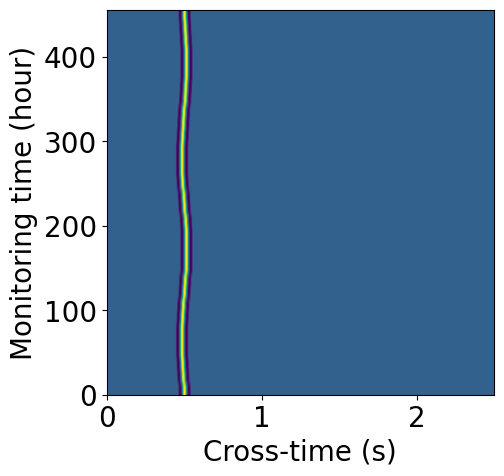

In [2]:
points = 20
a = 4.0
sizemax=32
vec2 = signal.ricker(points, a)
x = np.linspace(0,4*np.pi,sizemax)   # start,stop,step
y = np.sin(x)
maxlag=2501
M=np.zeros((sizemax,maxlag))
import random
fs=250
d=300
t=np.linspace(-1250/fs,1251/fs,maxlag)
IDX=[]
v=600
J=[]
for i in range(sizemax):
    noise = np.random.normal(0,1,maxlag) ## add noise to the correlograms
    i1=d/(v*(1+3*y[i]*10**-2)+0.05*t[i]) ## compute index
    idx=find_nearest(t,i1) ##find nearest index
    I=idx
    J.append(idx)
    M[i,I-10:I+10]=vec2 # Add gaussian or ricker
    #M[i,:]=M[i,:]+0.05*noise # re-add noise
    '''

    i1=d/(360*(1+y[i]*10**-2))
    idx=find_nearest(t,i1)
    I=idx
    M[i,I-10:I+10]=vec2
    i1=d/(100*(1+y[i]*10**-2))
    idx=find_nearest(t,i1)
    I=idx
    M[i,I-20:I+20]=vec2
    '''
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w', edgecolor='k')
ax.imshow(M,extent=[t[0],t[-1],0,456],aspect='auto',origin='lower')
ax.set_ylabel('Monitoring time (hour)',fontsize=20)
ax.set_xlabel('Cross-time (s)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0,2.5)

# TS

In [3]:
order=1  # 1
stacks=1 # 6
lisse_SG=3 # 3

lisse_SG=21# A enlever si jamais

option_smoothing_dv=0
option_normalisation_dv=0
option_filtre_dv=0
v=0
precision=0
eps=10
vmin=0
K=0
vmax=0
fs=250
lisse_SG=3 # 3
eps=1    #5
i=15
mode='Causale'
f1=1
f2=5
dvf1=f1
dvf2=f2
i=1
save_path=rf'G:/Numerical/'
st1='full_waveform'
st2='A'
t1=0.25#0.5#0.05
t2=0.75#1
fig=1 # or None
__make_stretch(((np.asarray((M)))).copy(),stacks,option_filtre_dv,
                                option_smoothing_dv,option_normalisation_dv,d,v,t,dvf1,dvf2,
                                lisse_SG,maxlag,mode,precision,save_path,vmin,vmax,t1,t2,st1,st2,eps,K,0)

C:\Users\tgaubert001\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\tgaubert001\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Save in G:/Numerical/1_5/full_waveform/


Text(0.5, 1, '(c)')

C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


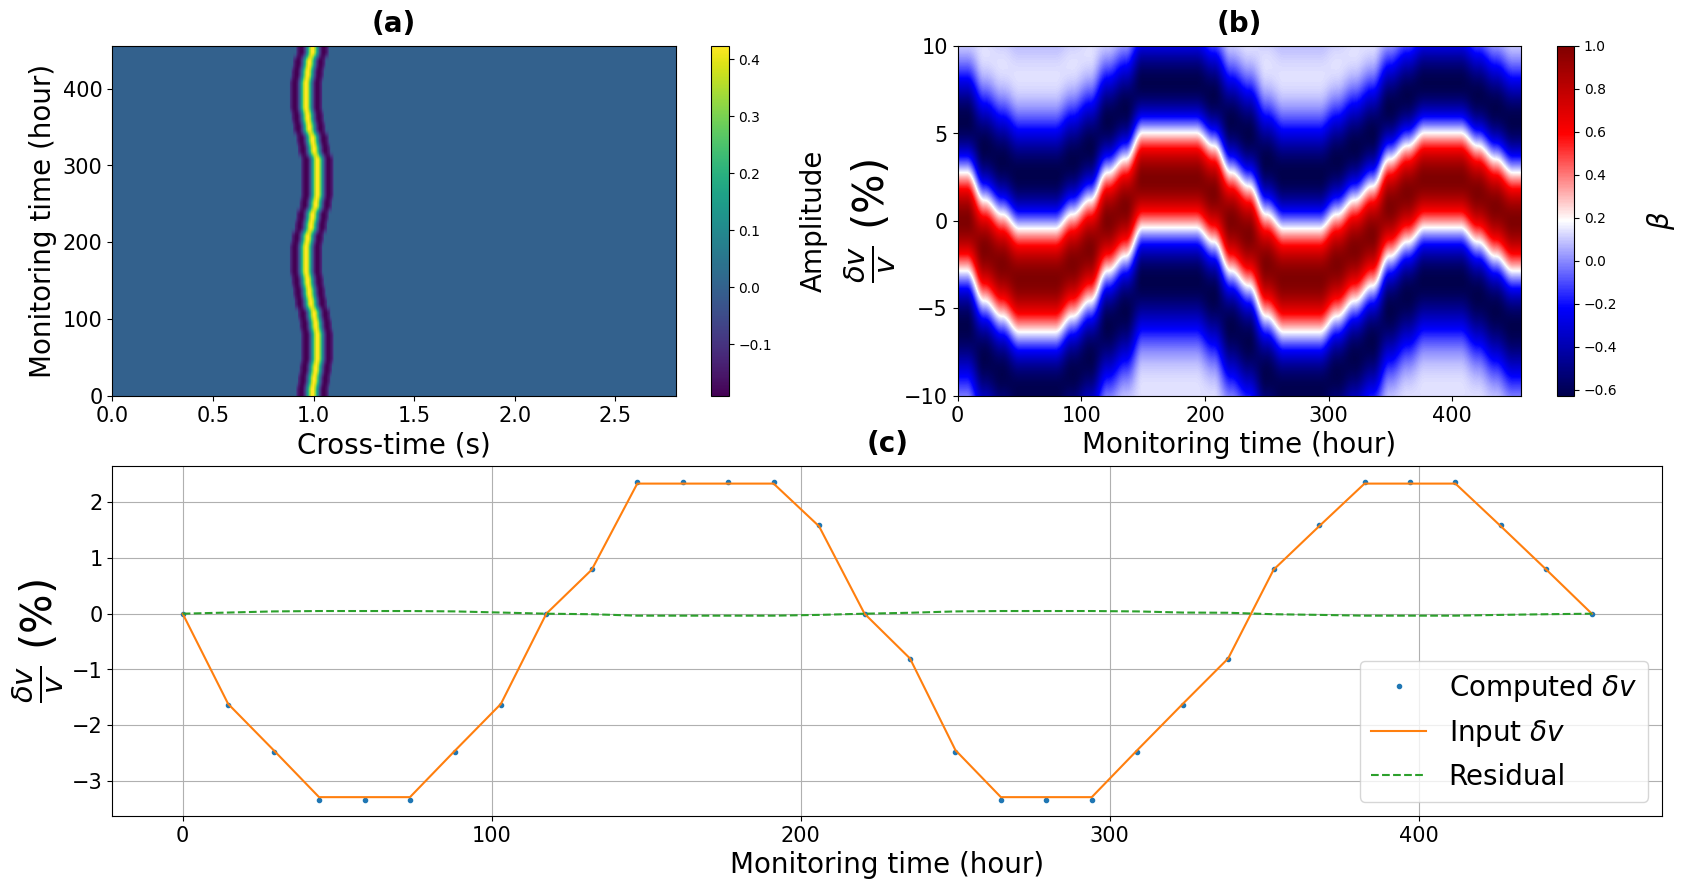

In [4]:
S=np.load(rf'{save_path}/{f1}_{f2}/{st1}/{K}_cc_{st1}_{st2}_{mode}_{t1}_{t2}_{f1}_{f2}.npy')
dvts=np.load(rf'{save_path}/{f1}_{f2}/{st1}/{K}_dv_{st1}_{st2}_{mode}_{t1}_{t2}_{f1}_{f2}.npy')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
EPSILON=np.arange(-eps*10e-2,eps*10e-2+1e-4,1e-5)

fig = plt.figure(figsize=(20,10),constrained_layout=True)
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0, 0])
im1=ax.imshow(M,extent=[-2500/fs,2500/fs,0,456],aspect='auto')
ax.set_ylabel('Monitoring time (hour)',fontsize=20)
ax.set_xlabel('Cross-time (s)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0/fs,700/fs)
cbar=fig.colorbar(im1, ax=ax)
cbar.ax.set_ylabel('Amplitude',  labelpad=20,fontsize=20)
cbar.ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('(a)',fontsize=20,pad=10,y=1,fontweight="bold")

ax1 = plt.subplot(gs[0, 1])
im1=ax1.imshow(S,extent=[0,456,100*EPSILON[0],100*EPSILON[-1]],aspect='auto',cmap='seismic')
ax1.set_ylabel(r'$\frac{\delta v}{v} $ (%)',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title('(b)',fontsize=20,pad=10,y=1,fontweight="bold")

ax1.set_xlabel('Monitoring time (hour)',fontsize=20)
cbar=fig.colorbar(im1, ax=ax1)
cbar.ax.set_ylabel(r'$\beta$',  labelpad=20,fontsize=20)
cbar.ax.tick_params(axis='both', which='major', labelsize=10)
ax = plt.subplot(gs[1, :])
tt=np.linspace(0,456,dvts.size)
ax.plot(tt,-dvts,'.',label='Computed $\delta v$')
DV=(100-100*(d/t[J]/(d/t[J[0]])))
ax.plot(tt,DV,label='Input $\delta v$')
ax.plot(tt,DV-(-dvts),'--',label='Residual')
ax.set_xlabel('Monitoring time (hour)',fontsize=20)
ax.set_ylabel(r'$\frac{\delta v}{v} $ (%)',fontsize=30)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid()
ax.set_title('(c)',fontsize=20,pad=10,y=1,fontweight="bold")

#plt.savefig(rf'F:\Fig_to_make/dvv.pdf',bbox_inches='tight',format='pdf',dpi=300)
#plt.savefig(rf'F:\Fig_to_make/dvv.jpg',bbox_inches='tight',format='jpg',dpi=300)  

# MCWS

In [5]:

'''
    ref: Reference waveform (np.ndarray, size N)
    cur: Current waveform (np.ndarray, size N)
    moving_window_length: moving window length to calculate cross-spectrum (np.float, in sec)
    slide_step: steps in time to shift the moving window (np.float, in seconds)
    para: a dict containing parameters about input data window and frequency info, including 
        delta->The sampling rate of the input timeseries (in Hz)
        window-> The target window for measuring dt/t
        freq-> The frequency bound to compute the dephasing (in Hz)
        tmin: The leftmost time lag (used to compute the "time lags array")
    smoothing_half_win: If different from 0, defines the half length of the smoothing hanning window.
'''

ref=M[0][1250::]
para = {'t': t_homo, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}
dvmcws=[]
f_min=1
f_max=250
dt=1/fs
dv_range=5
nbtrial=10
allfreq=1
t_min=50/fs
t_max=200/fs
t_homo=np.linspace(0,1250/fs,1251)
f_min=1
f_max=250
para = {'t': t_homo, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}
for i in range(sizemax):
    cur=M[i][1250::]
    step=0.2
    moving_window_length=0.5
    dv=mwcs_dvv(ref, cur, moving_window_length,step, para, smoothing_half_win=1)
    dvmcws.append(dv)

C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:1171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:529: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:1216: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:1216: R

# DTW 

In [7]:
""" Original by Di Yang
    Last modified by Dylan Mikesell (25 Feb. 2015)
    Translated to python by Tim Clements (17 Aug. 2018)    
    Dynamic time warping for dv/v estimation.
    PARAMETERS:
    ----------------
    ref : reference signal (np.array, size N)
    cur : current signal (np.array, size N)
    para: dict containing useful parameters about the data window and targeted frequency
    maxLag : max number of points to search forward and backward. 
            Suggest setting it larger if window is set larger.
    b : b-value to limit strain, which is to limit the maximum velocity perturbation. 
            See equation 11 in (Mikesell et al. 2015)
    direction: direction to accumulate errors (1=forward, -1=backward)
    RETURNS:
    ------------------
    -m0 : estimated dv/v
    em0 : error of dv/v estimation
    t = para['t']
    twin = para['twin']
    dt   = para['dt']
    tmin = np.min(twin)
    tmax = np.max(twin)  
    itvec = np.arange(np.int((tmin-t.min())/dt)+1, np.int((tmax-t.min())/dt)+1)    
    tvec = t[itvec]

"""
f_min=1
f_max=250
dt=1/fs
dv_range=5
nbtrial=10
allfreq=1
t_min=50/fs
t_max=150/fs
t_homo=np.linspace(0,1250/fs,1251)
f_min=1
f_max=250
para = {'t': t_homo, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}
dvdtw=[]
b=10
maxLag=10
ref=M[0][1250::]
for i in range(sizemax):
    cur=M[i][1250::]
    dv,err,d=dtw_dvv(ref, cur, para, maxLag, b, 1)
    dvdtw.append(dv)

C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:1096: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# WCC

In [8]:
"""
    Windowed cross correlation (WCC) for dt or dv/v mesurement (Snieder et al. 2012)
    Parameters:
    -----------
    ref: The "Reference" timeseries
    cur: The "Current" timeseries
    moving_window_length: The moving window length (in seconds)
    slide_step: The step to jump for the moving window (in seconds)
    para: a dict containing freq/time info of the data matrix
    Returns:
    ------------
    time_axis: central times of the moving window
    delta_t: dt
    delta_err: error
    delta_mcoh: mean coherence for each window
    Written by Congcong Yuan (1 July, 2019)
    Modified by Gaubert - Bastide 2023
""" 
f_min=1
f_max=250
dt=1/fs
dv_range=5
nbtrial=10
allfreq=1
t_min=50/fs
t_max=200/fs
t_homo=np.linspace(0,1250/fs,1251)
f_min=1
f_max=250
para = {'t': t_homo, 'twin': [t_min, t_max],'freq': [f_min, f_max], 'dt': dt}
dvwcc=[]
b=10
maxLag=10
ref=M[0][1250::]
slide_step=0.2
moving_window_length=0.5
for i in range(sizemax):
    cur=M[i][1250::]
    dv,err=WCC_dvv(ref, cur, moving_window_length, slide_step, para)
    dvwcc.append(dv)
dvwcc=-(dvwcc-dvwcc[0])

# Synthetic results

Text(0, 0.5, '$\\frac{\\delta v}{v}$ (%)')

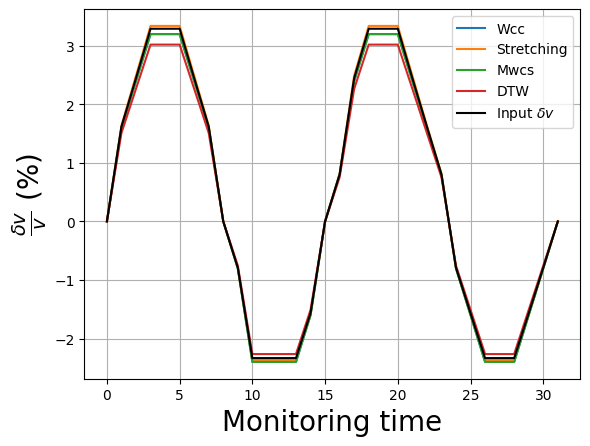

In [9]:
d=300 #distance
plt.plot(dvwcc,label='Wcc')
plt.plot(dvts,label='Stretching')
plt.plot(dvmcws,label='Mwcs')
plt.plot(dvdtw,label='DTW')
DV=(100-100*(d/t[J]/(d/t[J[0]])))
plt.plot(-DV,'k',label='Input $\delta v$')
plt.grid()
plt.legend()
plt.xlabel('Monitoring time',fontsize=20)
plt.ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=20)